In [12]:
# Importieren der benötigten Bibliotheken

# Datenmanipulation
import pandas as pd
import pickle

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, confusion_matrix

# Finales Modell: Hyperparameter Tuning


In [2]:
# Einlesen der Trainings- und Testdaten
destination_path = "../data/processed"

features_train = pd.read_csv(f"{destination_path}/features_train.csv")
features_test = pd.read_csv(f"{destination_path}/features_test.csv")
target_train = pd.read_csv(f"{destination_path}/target_train.csv")
target_test = pd.read_csv(f"{destination_path}/target_test.csv")

# Zielvariablen in einem Dictionary organisieren
targets = {
    "compressor": {
        "train": target_train.iloc[:, 0],
        "test": target_test.iloc[:, 0]
    },
    "turbine": {
        "train": target_train.iloc[:, 1],
        "test": target_test.iloc[:, 1]
    }
}

**Feature Selection**


In [3]:
# Einlesen der Top 10 Features importances basierend auf den Ergebnissen aus 03_baseline_model.ipynb
result_path = "../data/results"
top_features_comp = pd.read_csv(f"{result_path}/top_10_feature_importances_compressor.csv")
top_features_turb = pd.read_csv(f"{result_path}/top_10_feature_importances_turbine.csv")

# Auswahl der Top N Features Importances 
N_TOP_FEATURES = 3

important_features = {
    "compressor": top_features_comp.head(N_TOP_FEATURES)["Feature"].tolist(),
    "turbine": top_features_turb.head(N_TOP_FEATURES)["Feature"].tolist()
} 

print(f"Top {N_TOP_FEATURES} Features:")
print(f"Kompressor: {important_features['compressor']}")
print(f"Turbinen: {important_features['turbine']}")

Top 3 Features:
Kompressor: ['gt_compressor_outlet_air_temperature_t2_c', 'hp_turbine_exit_pressure_p48_bar', 'gt_exhaust_gas_pressure_pexh_bar']
Turbinen: ['gt_compressor_outlet_air_pressure_p2_bar', 'gas_generator_rate_of_revolutions_ggn_rpm', 'gas_turbine_gt_shaft_torque_gtt_kn_m']


**Hyperparameter-Optimierung mit GridSearchCV**


In [ ]:
# Parameter-Grid für den Random Forest
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 20, 30],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

best_models = {}

# Schleife für Kompressor und Turbine
for target_name, target_data in targets.items():
    print(f"GridSearchCV für: {target_name}")

    # Feature Selection für Kompressor und Turbine
    current_features = important_features[target_name]
    features_train_select = features_train[current_features]

    # Initialisierere die Grid Search
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

    # Trainiere mit den ausgewählten Features
    grid_search.fit(features_train_select, target_data["train"]) # Führe die Grid Search durch
    best_models[target_name] = grid_search.best_estimator_ 
    
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Bester R2 (CV): {grid_search.best_score_:.4f}\n")

GridSearchCV für: compressor
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Bester R2 (CV): 0.9741

GridSearchCV für: turbine
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Bester R2 (CV): 0.9631



**Finale Evaluation und Speicherung**


Finale Performance compressor auf Test-Set
R2 Score: 0.9753

Finale Performance turbine auf Test-Set
R2 Score: 0.9651



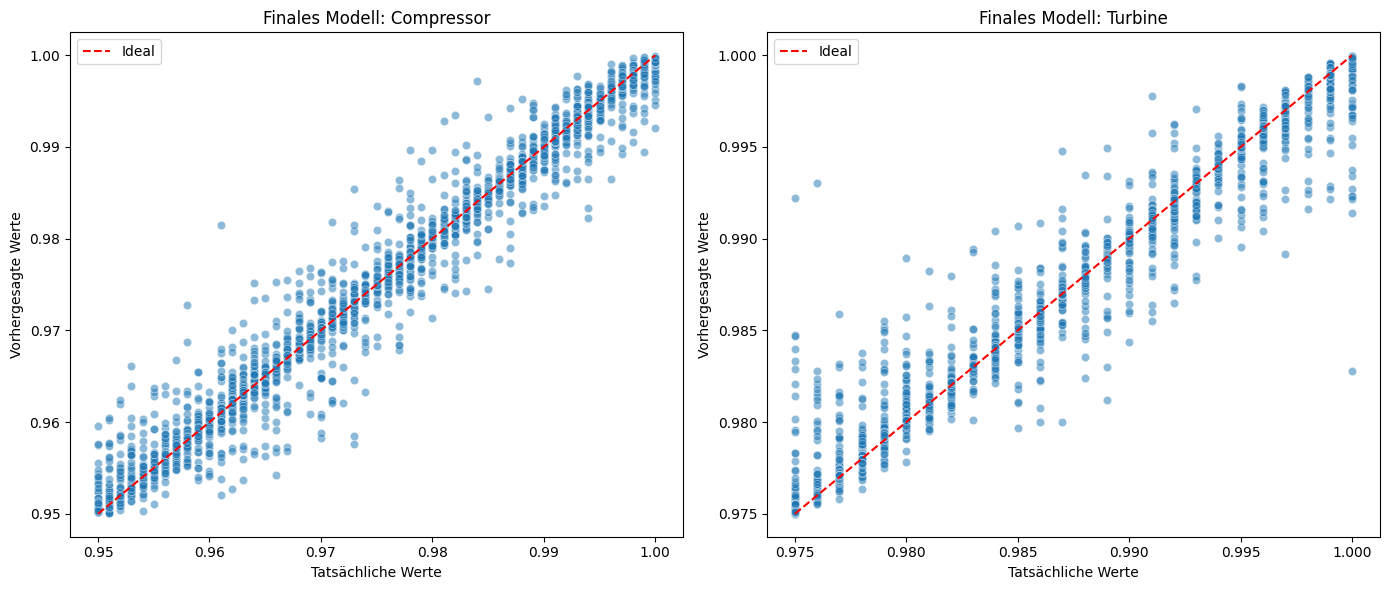

In [5]:
# Evaluieren und Speichern der optimierten Modelle
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

predictions_dict = {}

# Schleife für Kompressor und Turbine
for i, (target_name, best_model) in enumerate(best_models.items()):
    # Vorhersagen auf dem Test-Set
    current_features = important_features[target_name]
    features_test_select = features_test[current_features]
    
    predictions = best_model.predict(features_test_select)
    predictions_dict[target_name] = predictions
    r2 = r2_score(targets[target_name]['test'], predictions)
    
    print(f"Finale Performance {target_name} auf Test-Set")
    print(f"R2 Score: {r2:.4f}\n")
    
    # Speichern des Modells
    with open(f"../data/models/final_model_{target_name}.pkl", "wb") as file:
        pickle.dump(best_model, file)

    # Visualisierung der Vorhersagen
    ax = axes[i]
    sns.scatterplot(x=targets[target_name]["test"], y=predictions, alpha=0.5, ax=ax)

    ax.plot([targets[target_name]["test"].min(), targets[target_name]["test"].max()], 
             [targets[target_name]["test"].min(), targets[target_name]["test"].max()], 'r--', label='Ideal')
    ax.set_title(f'Finales Modell: {target_name.capitalize()}')
    ax.set_xlabel('Tatsächliche Werte')
    ax.set_ylabel('Vorhergesagte Werte')
    ax.legend()

plt.tight_layout()
plt.show()

**Anwendungsbezogene Evaluation: 2 Zerfallzustands Klassifikation**


In [ ]:
# Schwellenwerte für Zerfallzustand
thresholds = {
    'compressor': {'good': 0.98},
    'turbine': {'good': 0.99}
}

# Umwandlung in zwei Zustände
def get_binary_state(value, component_type):
    th = thresholds[component_type]
    return 'Gut' if value >= th['good'] else 'Handlungsbedarf'

# Wende die Funktion auf wahre und vorhergesagte Werte an
true_states = {
    'compressor': [get_binary_state(v, 'compressor') for v in targets['compressor']['test']],
    'turbine': [get_binary_state(v, 'turbine') for v in targets['turbine']['test']]
}

predicted_states = {
    'compressor': [get_binary_state(v, 'compressor') for v in predictions_dict['compressor']],
    'turbine': [get_binary_state(v, 'turbine') for v in predictions_dict['turbine']]
}

**Visualisierung 1: Farbcodierter Scatterplot**


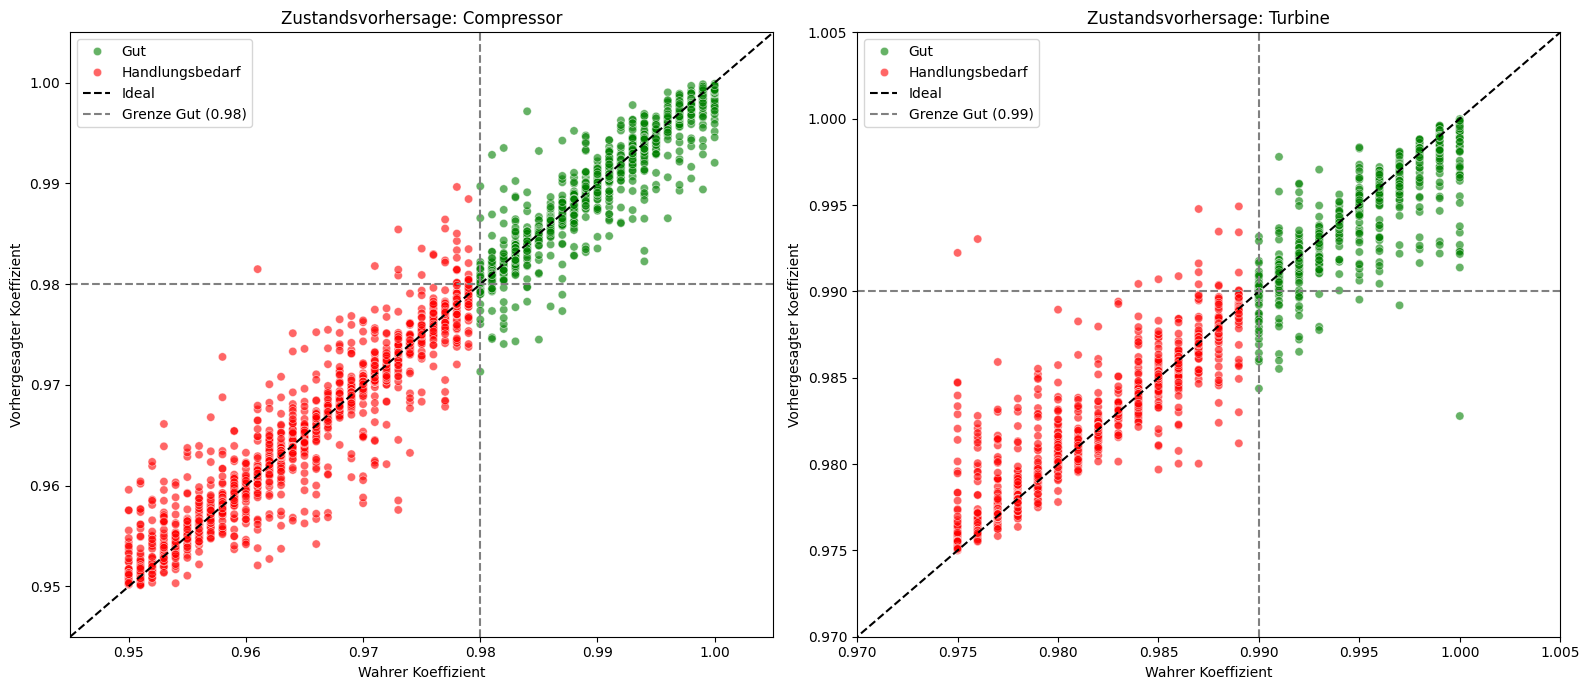

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
state_colors = {'Gut': 'green', 'Handlungsbedarf': 'red'}

for i, comp in enumerate(['compressor', 'turbine']):
    ax = axes[i]
    th = thresholds[comp]
    
    sns.scatterplot(x=targets[comp]['test'], y=predictions_dict[comp], hue=true_states[comp], 
                    palette=state_colors, alpha=0.6, ax=ax, hue_order=['Gut', 'Handlungsbedarf'])
    
    ax.plot([0.94, 1.01], [0.94, 1.01], 'k--', label='Ideal')
    
    ax.axvline(x=th['good'], color='grey', linestyle='--', label=f'Grenze Gut ({th["good"]})')
    ax.axhline(y=th['good'], color='grey', linestyle='--')
    
    ax.set_title(f'Zustandsvorhersage: {comp.capitalize()}')
    ax.set_xlabel('Wahrer Koeffizient')
    ax.set_ylabel('Vorhergesagter Koeffizient')
    ax.legend()
    ax.set_xlim(min(targets[comp]['test'].min(), min(predictions_dict[comp])) - 0.005, 1.005)
    ax.set_ylim(min(targets[comp]['test'].min(), min(predictions_dict[comp])) - 0.005, 1.005)

plt.tight_layout()
plt.show()

**Visualisierung 2: Konfusionsmatrix**


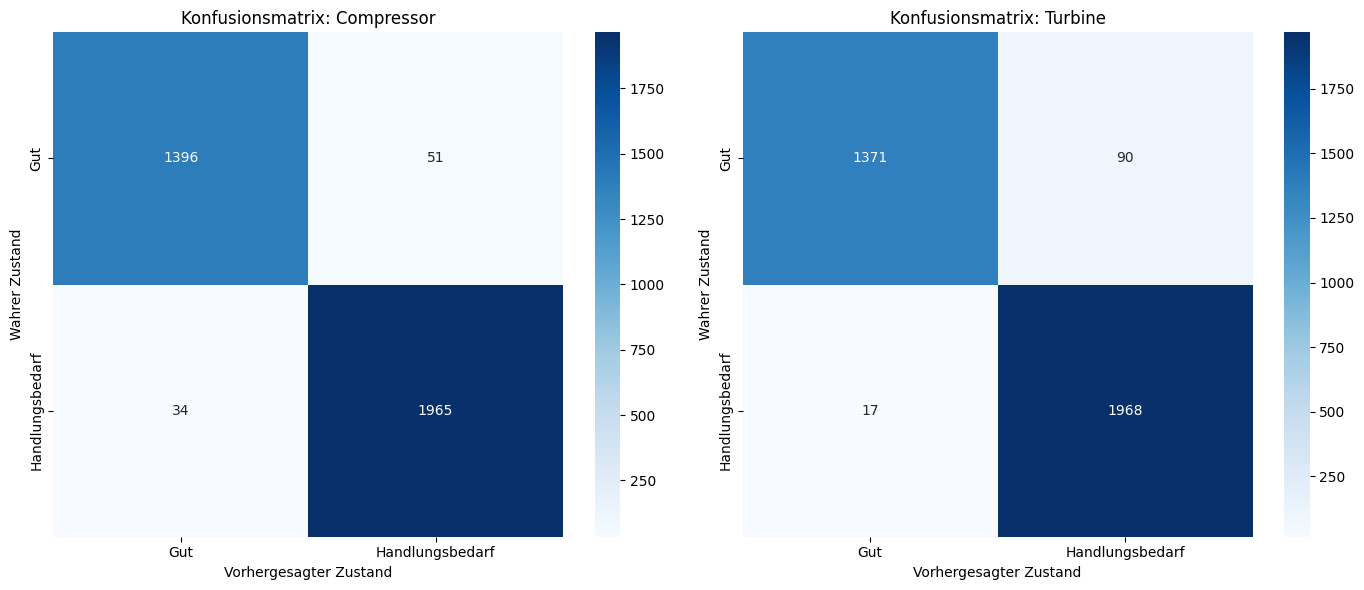

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
labels = ['Gut', 'Handlungsbedarf']

for i, comp in enumerate(['compressor', 'turbine']):
    ax = axes[i]
    cm = confusion_matrix(true_states[comp], predicted_states[comp], labels=labels)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    
    ax.set_title(f'Konfusionsmatrix: {comp.capitalize()}')
    ax.set_xlabel('Vorhergesagter Zustand')
    ax.set_ylabel('Wahrer Zustand')

plt.tight_layout()
plt.show()